# This notebook tries to find out thresholds for different methods based on their Dice scores

## This part is for our method (will need to change configs as we find better loss/arch etc.)

In [42]:
import argparse
import collections
import torch
import numpy as np
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from parse_config import ConfigParser
from trainer import VesselTrainer
from utils import dir2flow_2d, v2vesselness, overlay, overlay_quiver
from sklearn import metrics as M
from copy import deepcopy
import pickle as pkl

# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)


class Args:
    def __init__(self):
        self.config = 'configs/drivemaskv2_scale8.json'
#         self.config = 'configs/toydrive.json'
        self.resume = None
        self.run_id = ''
        self.device = None

args = Args()
IDX = 0

In [43]:
config = ConfigParser.from_args(args, '', parse=False)
# Augment some things here for dataloader
config.config['data_loader']['args']['augment'] = False
config.config['data_loader']['args']['validation_split'] = 0
config.config['data_loader']['args']['idx'] = IDX   # Use just one index

# config.config['optimizer']['args']['lr'] = 1e-2
# config.config['arch']['type'] = 'DeepLabV3'

data_loader = config.init_obj('data_loader', module_data)
config.config['data_loader']['args']['toy'] = True
gt_loader = config.init_obj('data_loader', module_data)

model = config.init_obj('arch', module_arch).cuda()
criterion = getattr(module_loss, config['loss'])
metrics = [getattr(module_metric, met) for met in config['metrics']]

trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = config.init_obj('optimizer', torch.optim, trainable_params)
lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)


backup_config = deepcopy(config)


Preserving indices:  [0]
Preserving indices:  [0]


In [44]:
print(dict(config['loss_args']))
# Change loss args here
pass
# config.config['loss_args']['lambda_intensity'] = 1
# config.config['loss_args']['lambda_consistency'] = 1

{'num_directions': 2, 'eps': 0.1, 'uncertainty': False, 'loss_intensity': 'L2', 'lambda_intensity': 0.1, 'lambda_consistency': 0.2, 'lambda_cosine': 1, 'lambda_decoder': 1, 'lambda_length': 1, 'lambda_template': 5, 'is_crosscorr': True, 'use_mask': True, 'detach': True, 'num_samples_template': 20, 'lambda_followupv': 0, 'lambda_perlength': 0.1}


In [45]:
%pylab
%matplotlib inline

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [46]:
def dice_score(a, b):
    num = (2*a*b).sum()
    den = a.sum() + b.sum()
    return num/den

In [47]:
'''
Run it for a single image
'''
def cuda(data):
    for k, v in data.items():
        data[k] = v.cuda()
    return data


def _train_epoch(epoch, gt=None, logepoch=100):
    """
    Training logic for an epoch

    :param epoch: Integer, current training epoch.
    :return: A log that contains average loss and metric in this epoch.
    """
    # Get parameters for quiver
    params = config['trainer']
    normflow = params.get('normalize_flow', True)
    normflowrev = params.get('normalize_flow_rev', True)
    quiverscale = params.get('quiver_scale', 2)
    
    # Get vessel type here
    vessel_type = config.get('vessel_type', 'light')
    
    auc = 0
    model.train()
    for batch_idx, data in enumerate(data_loader):
        # Move tensors to device
        data = cuda(data)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data, config)
        loss.backward()
        optimizer.step()
        
        mask = data.get('mask')
        if mask is not None:
            mask = mask.cpu()         
        
        if gt is None:
            print("Epoch: {}, Loss: {}".format(epoch, loss.data.cpu().numpy()))
        else:
            ves = v2vesselness(data['image'].cpu(), output['vessel'][:, 2:4].cpu(), \
               vtype=vessel_type, mask=mask, is_crosscorr=False)
            # Get auc value
            V = ves[0, 0].data.cpu().numpy()
            g = gt[0, 0].data.cpu().numpy().astype(int)
            V = (V - V.min())/(V.max() - V.min())
            fpr, tpr, thres = M.roc_curve(g.reshape(-1), V.reshape(-1), pos_label=1)
            auc = M.auc(fpr, tpr)
            print("Epoch: {}, Loss: {:2f}, AUC: {:2f}".format(epoch, loss.data.cpu().numpy(), auc))            

        
    if (epoch+1) % logepoch == 0:
        # Get images to inspect
        q1 = overlay_quiver(data['image'].cpu(), output['vessel'][:, 0:2].cpu(), quiverscale, normflowrev)
        q2 = overlay_quiver(data['image'].cpu(), output['vessel'][:, 2:4].cpu(), quiverscale, normflowrev)
        ves = v2vesselness(data['image'].cpu(), output['vessel'][:, 2:4].cpu(), \
                           vtype=vessel_type, mask=mask, is_crosscorr=False)
    else:
        q1 = q2 = None

    return q1, q2, ves, auc

In [48]:
auc_list = []

for data in gt_loader:
    gt = data['image']
    break

Epoch: 0, Loss: 4.585980, AUC: 0.896174
Epoch: 1, Loss: 3.573590, AUC: 0.898798
Epoch: 2, Loss: 3.507918, AUC: 0.900111
Epoch: 3, Loss: 3.374743, AUC: 0.891134
Epoch: 4, Loss: 3.276771, AUC: 0.891255
Epoch: 5, Loss: 3.088289, AUC: 0.893079
Epoch: 6, Loss: 2.832937, AUC: 0.896090
Epoch: 7, Loss: 2.971285, AUC: 0.901516
Epoch: 8, Loss: 3.105030, AUC: 0.905894
Epoch: 9, Loss: 2.991077, AUC: 0.906630
Epoch: 10, Loss: 2.890371, AUC: 0.903129
Epoch: 11, Loss: 2.897023, AUC: 0.901708
Epoch: 12, Loss: 2.926217, AUC: 0.902868
Epoch: 13, Loss: 2.937032, AUC: 0.903253
Epoch: 14, Loss: 2.893828, AUC: 0.903693
Epoch: 15, Loss: 2.825638, AUC: 0.903274
Epoch: 16, Loss: 2.859798, AUC: 0.903329
Epoch: 17, Loss: 2.863257, AUC: 0.903516
Epoch: 18, Loss: 2.843982, AUC: 0.904240
Epoch: 19, Loss: 2.800368, AUC: 0.905174
Epoch: 20, Loss: 2.749177, AUC: 0.905027
Epoch: 21, Loss: 2.757520, AUC: 0.905509
Epoch: 22, Loss: 2.761095, AUC: 0.905601
Epoch: 23, Loss: 2.748430, AUC: 0.905754
Epoch: 24, Loss: 2.740983,

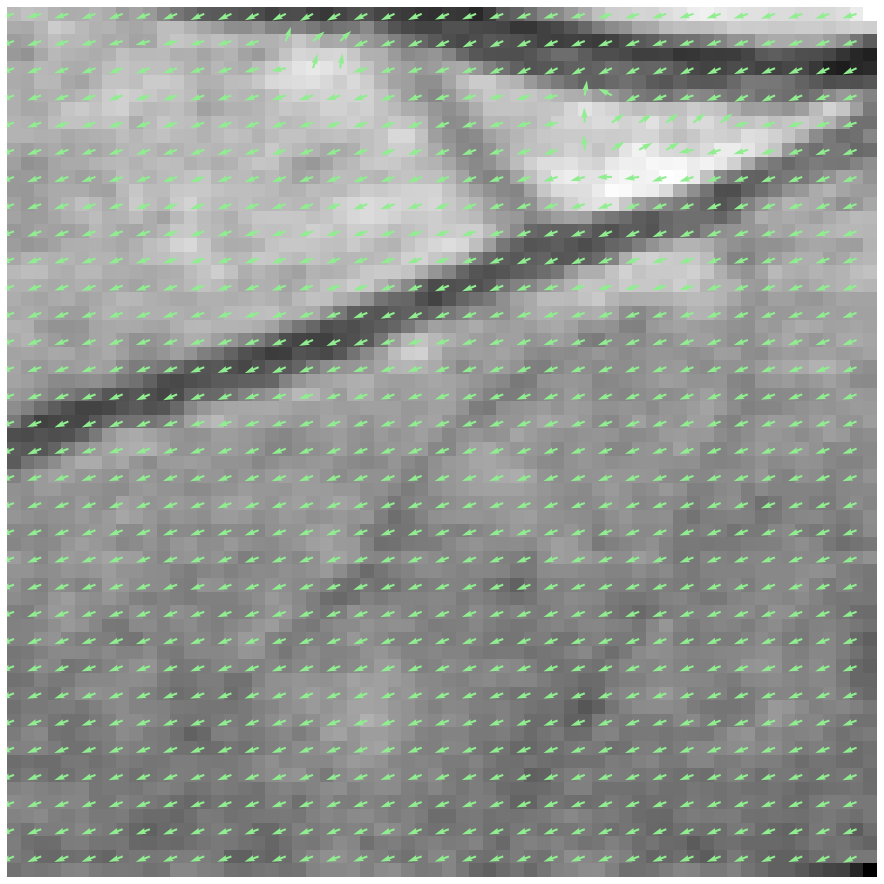

In [8]:
for _ in range(50):
    q1, q2, ves, auc = _train_epoch(_, gt, 10)
    auc_list.append(auc)

# plt.clf()
# plt.figure(figsize=(10, 30))
# plt.subplot(311)
# plt.imshow(q1[0].data.cpu().numpy().transpose(1, 2, 0)/255.)
# plt.axis('off')
# plt.subplot(312)
# plt.imshow(q2[0].data.cpu().numpy().transpose(1, 2, 0)/255.)   
# plt.axis('off')
# plt.subplot(313)
# plt.imshow(ves[0, 0].data.cpu().numpy(), 'jet')
# plt.axis('off')

## Get AUC scores and evaluate at each threshold

In [49]:
V = ves[0, 0].data.cpu().numpy()
V = (V - V.min())/(V.max() - V.min())
mask = data['mask'][0, 0].data.cpu().numpy()
g = gt[0, 0].data.cpu().numpy()
g = (g > 0.5).astype(float)

In [50]:
fpr, tpr, thres = M.roc_curve(g.reshape(-1).astype(int), V.reshape(-1), pos_label=1)
auc = M.auc(fpr, tpr)
print(auc)

0.6832592180969512


In [51]:
dice = []
for t in thres:
    vthres = (V > t).astype(float)
    # Given thresholded image, get dice score
    d = dice_score(vthres, g)
    dice.append(d)

KeyboardInterrupt: 

In [ ]:
max_idx = np.argmax(dice)
max_thres = thres[max_idx]
max_d = dice[max_idx]
print("Maximum dice score: {} achieved at threshold = {}".format(max_d, max_thres))

In [ ]:
plt.figure(figsize=(16, 16))
plt.subplot(121)
plt.imshow(g, 'gray')
plt.subplot(122)
plt.imshow(V > max_thres, 'gray')

----------------------

# Frangi

Here we'll try to determine the best threshold for Frangi in a similar way.

In [52]:
from skimage.filters import frangi

for data in data_loader:
    img = data['image'].data.cpu().numpy()[0, 0]
    break

In [53]:
frangives = frangi(img, np.linspace(1, 5, 10), black_ridges=True).astype(np.float32)*mask

In [54]:
# Get AUC here
fpr, tpr, thres = M.roc_curve(g.reshape(-1).astype(int), frangives.reshape(-1), pos_label=1)
auc = M.auc(fpr, tpr)
print(auc)

0.9481921363930657


In [55]:
dice = []
for t in thres:
    vthres = (frangives > t).astype(float)
    # Given thresholded image, get dice score
    d = dice_score(vthres, g)
    dice.append(d)

In [56]:
f_max_idx = np.argmax(dice)
f_max_thres = thres[max_idx]
f_max_d = dice[max_idx]
print("Maximum dice score: {} achieved at threshold = {}".format(f_max_d, f_max_thres))

Maximum dice score: 0.6807953950811093 achieved at threshold = 2.7961922910435533e-07


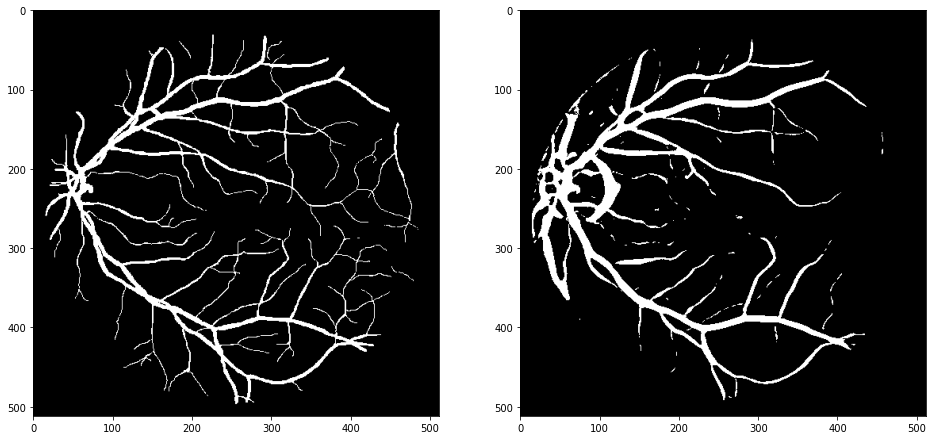

In [58]:
mask = data['mask'][0, 0].data.cpu().numpy()
g = gt[0, 0].data.cpu().numpy()
g = (g > 0.5).astype(float)

plt.figure(figsize=(16, 16))
plt.subplot(121)
plt.imshow(g, 'gray')
plt.subplot(122)
plt.imshow(frangives > 2.7961922910435533e-07, 'gray')

--------------
# Vesselness from file

In [62]:
with open('./drive_sq8_300.pkl', 'rb') as fi:
# with open('drive_contrast8_525.pkl', 'rb') as fi:
    data_ = pkl.load(fi)

In [63]:
# Get AUC here
fpr, tpr, thres = M.roc_curve(g.reshape(-1).astype(int), data_[IDX, 0].reshape(-1), pos_label=1)
auc = M.auc(fpr, tpr)
print(auc)

0.9224460071963598


In [65]:
dice = []
for t in thres:
    vthres = (data_[IDX, 0] > t).astype(float)
    # Given thresholded image, get dice score
    d = dice_score(vthres, g)
    dice.append(d)

In [66]:
F_max_idx = np.argmax(dice)
F_max_thres = thres[max_idx]
F_max_d = dice[max_idx]
print("Maximum dice score: {} achieved at threshold = {}".format(F_max_d, F_max_thres))

Maximum dice score: 0.6642606180836063 achieved at threshold = 0.09590119123458862


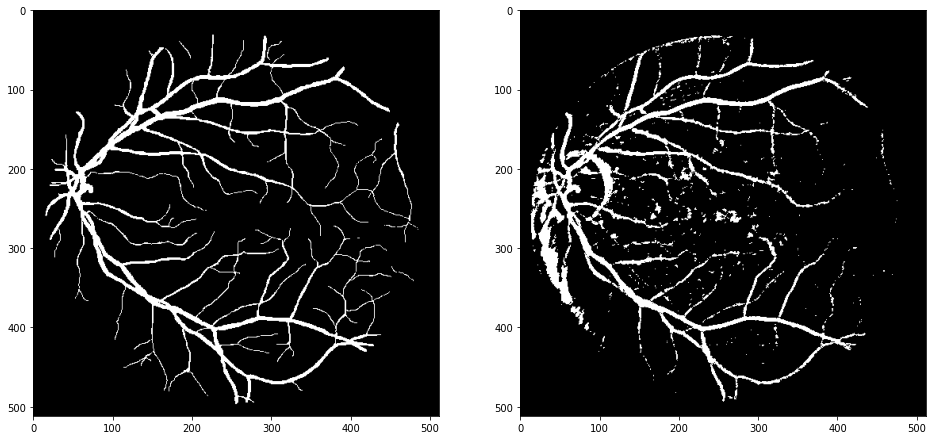

In [67]:
plt.figure(figsize=(16, 16))
plt.subplot(121)
plt.imshow(g, 'gray')
plt.subplot(122)
plt.imshow(data_[IDX, 0] > 0.0959, 'gray')
# plt.imshow(data_[IDX, 0] > 0.23, 'gray')

------------------------------

# Collecting results here
## [CAUTION]

This part will have the threshold values from different runs, and we'll take an average of them.

In [24]:
print(max_thres, f_max_thres)

0.35897118 3.8604924e-07


In [22]:
'''
BE CAREFUL with this part
'''
threshold_ours = [0.5308043956756592, 0.5867383480072021, 0.5557414889335632, 0.4445055425167084, 0.35897117853164673]
threshold_frangi = [4.14647615798458e-07, 2.9678446367142897e-07, 2.9782495403196663e-7, 5.255294581729686e-07, 3.860492370222346e-07]

In [23]:
print("Mean threshold with our method: {}".format(np.mean(threshold_ours)))
print("Mean threshold with Frangi: {}".format(np.mean(threshold_frangi)))

Mean threshold with our method: 0.49535219073295594
Mean threshold with Frangi: 3.841671457394114e-07
